In [1]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import datasets
from mlxtend.data import loadlocal_mnist
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

<center><span style="font-size:24px; font-weight:bold;">Image Classification with HOG Feature and Support Vector Machine</span></center>

<span style="font-size:20px; font-weight:bold;">1. Dataset Preparation</span>

<span style="font-size:16px; font-weight:bold;">File Location</span>

In [2]:
!ls ../emnist_source_files/

emnist-letters-test-images-idx3-ubyte
emnist-letters-test-labels-idx1-ubyte
emnist-letters-train-images-idx3-ubyte
emnist-letters-train-labels-idx1-ubyte


<span style="font-size:16px; font-weight:bold;">Load Image Dataset</span>

In [3]:
train_images, train_labels = loadlocal_mnist(images_path='../emnist_source_files/emnist-letters-train-images-idx3-ubyte', 
                                             labels_path='../emnist_source_files/emnist-letters-train-labels-idx1-ubyte')

In [4]:
test_images, test_labels = loadlocal_mnist(images_path='../emnist_source_files/emnist-letters-test-images-idx3-ubyte', 
                                           labels_path='../emnist_source_files/emnist-letters-test-labels-idx1-ubyte')

In [5]:
train_images

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
train_images.shape

(124800, 784)

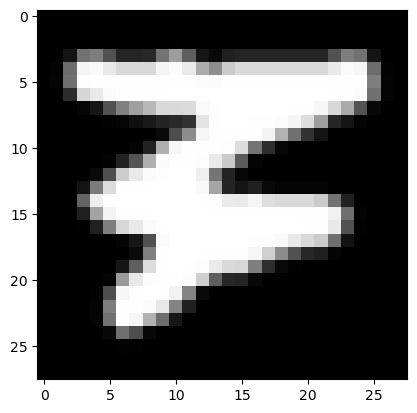

In [7]:
plt.imshow(train_images[0].reshape(28, 28), cmap='gray')

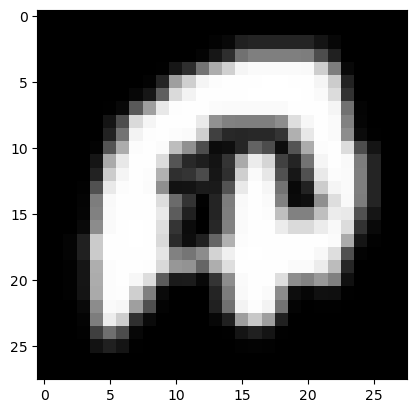

In [8]:
plt.imshow(train_images[1].reshape(28, 28), cmap='gray')

In [9]:
import string

letters = string.ascii_uppercase  # 'A' sampai 'Z'
label_index = train_labels[0] - 1  # karena EMNIST Letters dimulai dari 1
letters[label_index]

'W'

In [10]:
import string

letters = string.ascii_uppercase  # 'A' sampai 'Z'
label_index = train_labels[1] - 1  # karena EMNIST Letters dimulai dari 1
letters[label_index]

'G'

<span style="font-size:16px; font-weight:bold;">Text Extract HOG Feature From Image</span>

In [11]:
feature, hog_img= hog(train_images[0].reshape(28, 28), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2' )

In [12]:
feature.shape

(144,)

<BarContainer object of 144 artists>

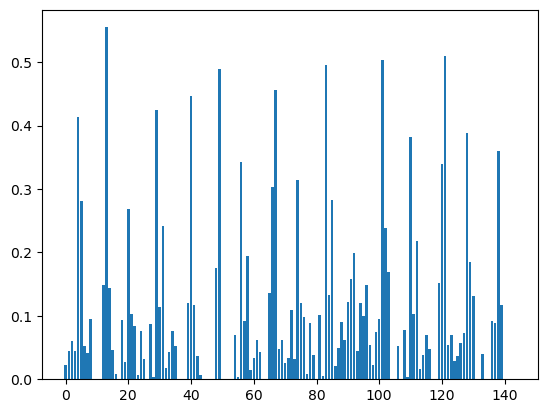

In [13]:
plt.bar(list(range(feature.shape[0])), feature)

In [14]:
feature, hog_img= hog(train_images[1].reshape(28, 28), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2' )

In [15]:
feature.shape

(144,)

<BarContainer object of 144 artists>

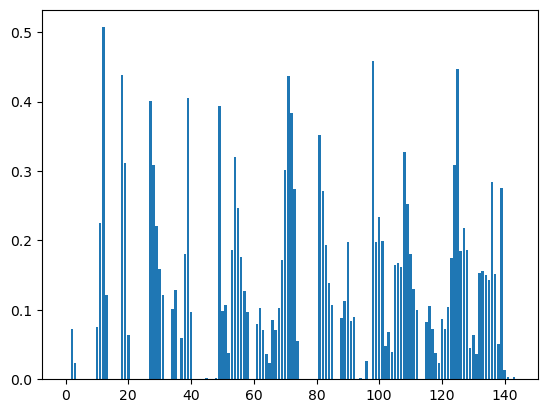

In [16]:
plt.bar(list(range(feature.shape[0])), feature)

<span style="font-size:20px; font-weight:bold;">2. Preprocessing Using HOG Feature Extraction</span>

In [17]:
n_classes = 26
samples_per_class = 500
total_samples = n_classes * samples_per_class

selected_idx = []
for label in range(1, n_classes + 1):  # label EMNIST Letters mulai dari 1
    idx = np.where(train_labels == label)[0]
    chosen = np.random.choice(idx, samples_per_class, replace=False)
    selected_idx.extend(chosen)

selected_idx = np.array(selected_idx)
train_images_subset = train_images[selected_idx]
train_labels_subset = train_labels[selected_idx]

print("Subset shape:", train_images_subset.shape)
print("Labels shape:", train_labels_subset.shape)

Subset shape: (13000, 784)
Labels shape: (13000,)


In [18]:
sample_feature, _ = hog(train_images_subset[0].reshape(28, 28),
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True,
                        block_norm='L2-Hys')

n_features = sample_feature.shape[0]
x_train = np.zeros((total_samples, n_features))
y_train = np.zeros(total_samples)

for i in tqdm(range(total_samples)):
    feature, _ = hog(train_images_subset[i].reshape(28, 28),
                     orientations=9,
                     pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2),
                     visualize=True,
                     block_norm='L2-Hys')
    x_train[i] = feature
    y_train[i] = train_labels_subset[i]

print("HOG feature shape:", x_train.shape)

100%|██████████| 13000/13000 [00:13<00:00, 995.46it/s] 

HOG feature shape: (13000, 144)


<span style="font-size:20px; font-weight:bold;">3. Predict Test Dataset</span>

In [19]:
n_classes = 26
samples_per_class = 500
total_samples = n_classes * samples_per_class

selected_idx = []
for label in range(1, n_classes + 1):  # label EMNIST Letters mulai dari 1
    idx = np.where(test_labels == label)[0]
    chosen = np.random.choice(idx, samples_per_class, replace=False)
    selected_idx.extend(chosen)

selected_idx = np.array(selected_idx)
test_images_subset = test_images[selected_idx]
test_labels_subset = test_labels[selected_idx]

print("Subset shape:", test_images_subset.shape)
print("Labels shape:", test_labels_subset.shape)

Subset shape: (13000, 784)
Labels shape: (13000,)


In [23]:
sample_feature, _ = hog(test_images_subset[0].reshape(28, 28),
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True,
                        block_norm='L2-Hys')

n_features = sample_feature.shape[0]
x_test = np.zeros((total_samples, n_features))
y_test = np.zeros(total_samples)

for i in tqdm(range(total_samples)):
    feature, _ = hog(test_images_subset[i].reshape(28, 28),
                     orientations=9,
                     pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2),
                     visualize=True,
                     block_norm='L2-Hys')
    x_test[i] = feature
    y_test[i] = test_labels_subset[i]

print("HOG feature shape:", x_test.shape)

100%|██████████| 13000/13000 [00:13<00:00, 997.66it/s]

HOG feature shape: (13000, 144)


<span style="font-size:20px; font-weight:bold;">3. Training using SVM and Evaluasi using LOOCV</span>

In [25]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Inisialisasi Leave-One-Out Cross-Validation dan model SVM
loo = LeaveOneOut()
model = SVC(kernel='linear', C=10.0)

# Variabel untuk menyimpan hasil
y_true = []
y_pred = []

# Loop LOOCV
for train_index, test_index in loo.split(x_train):
    X_train_loo, X_test_loo = x_train[train_index], x_train[test_index]
    y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]

    # Melatih model SVM
    model.fit(X_train_loo, y_train_loo)

    # Prediksi untuk sampel uji
    y_pred_loo = model.predict(X_test_loo)

    # simpan hasil
    y_true.append(y_test_loo[0])
    y_pred.append(y_pred_loo[0])

# eval performa
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Menampilkan hasil eval performa
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("F1 Score:", f1)


Accuracy: 0.8126153846153846
Confusion Matrix:
 [[376   6   2  10   5   1   8  11   0   2   1   1   5   8  10   1  29   5
    1   2   3   0   7   1   1   4]
 [ 16 408   2   5   5   2   6  28   0   0   3   3   3   2   2   1   6   4
    1   1   1   0   1   0   0   0]
 [ 10   1 432   1  32   3   6   0   1   0   1   1   0   1   1   1   3   3
    1   0   2   0   0   0   0   0]
 [ 21  16   1 406   1   2   0   3   0  11   0   2   0   5  21   5   1   0
    1   2   1   0   1   0   0   0]
 [ 10   2  35   1 407  23   6   0   0   0   0   0   0   0   2   1   3   5
    3   0   0   0   0   0   0   2]
 [  1   2   3   2  18 413   4   0   3   2   0   1   0   0   1  10   4   9
    6  18   0   0   0   1   0   2]
 [ 12  14  21   2  11   4 309   1   1   2   2   1   0   1   0   1  98   0
    7   2   1   0   1   0   9   0]
 [  7  35   0   4   0   1   1 399   3   2   7   9   7  12   0   0   0   1
    0   2   2   0   3   1   4   0]
 [  2   0   1   8   1   5   3   2 321  16   1 127   0   1   1   2   1   0
    2 

<span style="font-size:20px; font-weight:bold;">4. Evaluasi Result</span>


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.67      0.75      0.71       500
         2.0       0.76      0.82      0.79       500
         3.0       0.83      0.86      0.85       500
         4.0       0.80      0.81      0.81       500
         5.0       0.80      0.81      0.81       500
         6.0       0.79      0.83      0.81       500
         7.0       0.68      0.62      0.65       500
         8.0       0.78      0.80      0.79       500
         9.0       0.63      0.64      0.63       500
        10.0       0.86      0.81      0.83       500
        11.0       0.87      0.85      0.86       500
        12.0       0.68      0.69      0.68       500
        13.0       0.86      0.89      0.87       500
        14.0       0.76      0.75      0.76       500
        15.0       0.90      0.91      0.90       500
        16.0       0.89      0.87      0.88       500
        17.0       0.66      0.71      0.68       

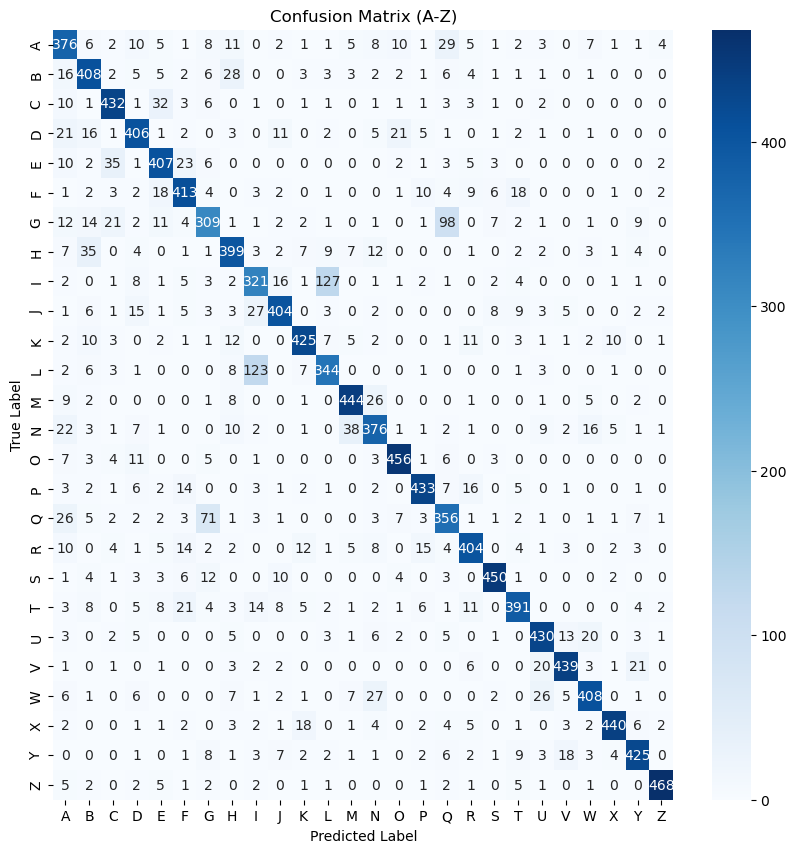

In [27]:
import seaborn as sns
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)

# Buat label huruf A-Z (sesuai EMNIST Letters)
labels = [chr(i) for i in range(65, 91)]  # 65='A', 90='Z'

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (A-Z)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

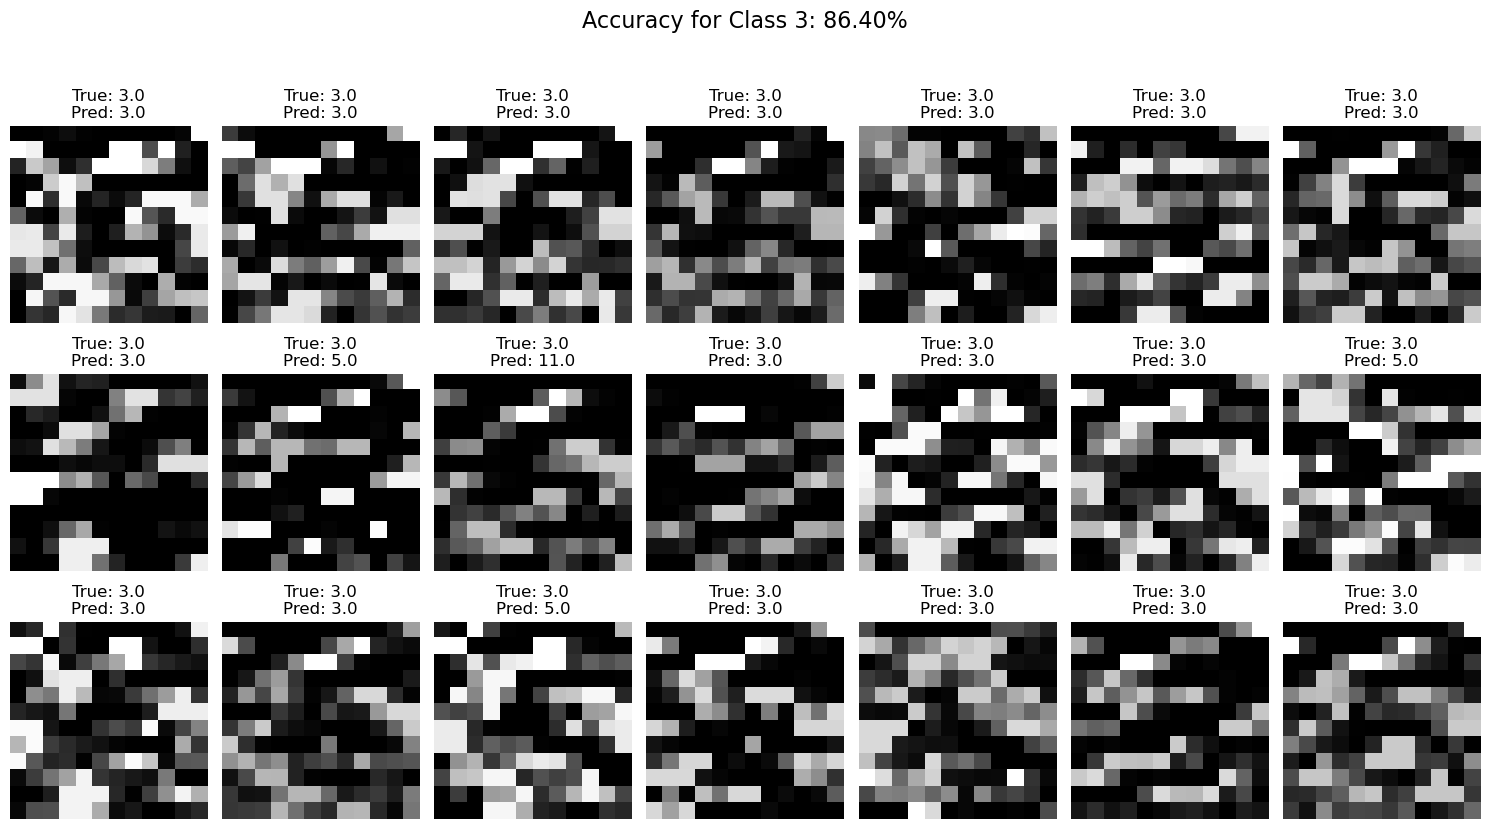

In [35]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Tentukan kelas yang ingin ditampilkan
target_class = 3

# Ambil indeks dari sampel di `y_test` yang sesuai dengan kelas target
indices_for_target_class = [i for i, label in enumerate(y_test) if label == target_class]

# Tentukan jumlah gambar yang ingin ditampilkan (21 gambar)
num_samples_to_show = 21
# Ambil sampel acak dari indeks yang sesuai
selected_indices = random.sample(indices_for_target_class, min(num_samples_to_show, len(indices_for_target_class)))

# Hitung akurasi untuk kelas yang ditargetkan
def calculate_accuracy(y_true, y_pred, target_class):
    correct_predictions = sum((y_pred[i] == y_true[i]) for i in range(len(y_true)) if y_true[i] == target_class)
    total_predictions = sum(1 for label in y_true if label == target_class)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

# Hitung akurasi untuk target_class
accuracy = calculate_accuracy(y_test, y_pred, target_class)

# Buat plot untuk menunjukkan gambar, prediksi, dan label aslinya
num_cols = 7  # Jumlah kolom
num_rows = (num_samples_to_show + num_cols - 1) // num_cols  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten axes array untuk memudahkan indexing
axes = axes.flatten()

for i, index in enumerate(selected_indices):
    ax = axes[i]
    image = x_test[index].reshape(12, 12)
    true_label = y_test[index]
    predicted_label = y_pred[index]

    # Tampilkan gambar
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'True: {true_label}\nPred: {predicted_label}')

# Menyembunyikan sisa subplot yang tidak digunakan
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Tampilkan akurasi di atas plot
plt.suptitle(f'Accuracy for Class {target_class}: {accuracy * 100:.2f}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Atur layout agar tidak bertabrakan dengan suptitle
plt.show()